In [ ]:
try:
    import numpyro
except ImportError:
    !pip install -q "llvmlite>=0.45.1" "numpyro[cpu]" matplotlib pandas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi

numpyro.set_host_device_count(1)

In [ ]:
def generate_data(key, n_groups=8, n_per_group=40):
    k1, k2, k3, k4 = random.split(key, 4)
    true_alpha = 1.0
    true_beta = 0.6
    sigma_alpha_g = 0.8
    sigma_beta_g = 0.5
    sigma_eps = 0.7
    group_ids = np.repeat(np.arange(n_groups), n_per_group)
    n = n_groups * n_per_group
    alpha_g = random.normal(k1, (n_groups,)) * sigma_alpha_g
    beta_g = random.normal(k2, (n_groups,)) * sigma_beta_g
    x = random.normal(k3, (n,)) * 2.0
    eps = random.normal(k4, (n,)) * sigma_eps
    a = true_alpha + alpha_g[group_ids]
    b = true_beta + beta_g[group_ids]
    y = a + b * x + eps
    df = pd.DataFrame({"y": np.array(y), "x": np.array(x), "group": group_ids})
    truth = dict(true_alpha=true_alpha, true_beta=true_beta,
                 sigma_alpha_group=sigma_alpha_g, sigma_beta_group=sigma_beta_g,
                 sigma_eps=sigma_eps)
    return df, truth

key = random.PRNGKey(0)
df, truth = generate_data(key)
x = jnp.array(df["x"].values)
y = jnp.array(df["y"].values)
groups = jnp.array(df["group"].values)
n_groups = int(df["group"].nunique())

In [ ]:
def hierarchical_regression_model(x, group_idx, n_groups, y=None):
    mu_alpha = numpyro.sample("mu_alpha", dist.Normal(0.0, 5.0))
    mu_beta = numpyro.sample("mu_beta", dist.Normal(0.0, 5.0))
    sigma_alpha = numpyro.sample("sigma_alpha", dist.HalfCauchy(2.0))
    sigma_beta = numpyro.sample("sigma_beta", dist.HalfCauchy(2.0))
    with numpyro.plate("group", n_groups):
        alpha_g = numpyro.sample("alpha_g", dist.Normal(mu_alpha, sigma_alpha))
        beta_g = numpyro.sample("beta_g", dist.Normal(mu_beta, sigma_beta))
    sigma_obs = numpyro.sample("sigma_obs", dist.Exponential(1.0))
    alpha = alpha_g[group_idx]
    beta = beta_g[group_idx]
    mean = alpha + beta * x
    with numpyro.plate("data", x.shape[0]):
        numpyro.sample("y", dist.Normal(mean, sigma_obs), obs=y)

nuts = NUTS(hierarchical_regression_model, target_accept_prob=0.9)
mcmc = MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=1, progress_bar=True)
mcmc.run(random.PRNGKey(1), x=x, group_idx=groups, n_groups=n_groups, y=y)
samples = mcmc.get_samples()

In [ ]:
def param_summary(arr):
    arr = np.asarray(arr)
    mean = arr.mean()
    lo, hi = hpdi(arr, prob=0.9)
    return mean, float(lo), float(hi)

for name in ["mu_alpha", "mu_beta", "sigma_alpha", "sigma_beta", "sigma_obs"]:
    m, lo, hi = param_summary(samples[name])
    print(f"{name}: mean={m:.3f}, HPDI=[{lo:.3f}, {hi:.3f}]")

predictive = Predictive(hierarchical_regression_model, samples, return_sites=["y"])
ppc = predictive(random.PRNGKey(2), x=x, group_idx=groups, n_groups=n_groups)
y_rep = np.asarray(ppc["y"])

group_to_plot = 0
mask = df["group"].values == group_to_plot
x_g = df.loc[mask, "x"].values
y_g = df.loc[mask, "y"].values
y_rep_g = y_rep[:, mask]

order = np.argsort(x_g)
x_sorted = x_g[order]
y_rep_sorted = y_rep_g[:, order]
y_med = np.median(y_rep_sorted, axis=0)
y_lo, y_hi = np.percentile(y_rep_sorted, [5, 95], axis=0)

plt.figure(figsize=(8, 5))
plt.scatter(x_g, y_g)
plt.plot(x_sorted, y_med)
plt.fill_between(x_sorted, y_lo, y_hi, alpha=0.3)
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.9/370.9 kB 7.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires llvmlite<0.44,>=0.43.0dev0, but you have llvmlite 0.45.1 which is incompatible.
          y         x  group
0 -0.241919  2.591272      0
1  0.557034  2.710021      0
2  3.489583 -0.819211      0
3  2.196636 -1.543771      0
4 -0.326444  0.761883      0 

True global alpha: 1.0
True global beta : 0.6


sample: 100%|██████████| 2000/2000 [00:06<00:00, 318.91it/s, 15 steps of size 3.79e-01. acc. prob=0.94]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_g[0]      1.78      0.10      1.77      1.62      1.97   1359.20      1.00
   alpha_g[1]      0.28      0.10      0.28      0.10      0.45   1323.70      1.00
   alpha_g[2]      0.38      0.11      0.38      0.21      0.57   1206.61      1.00
   alpha_g[3]     -0.05      0.10     -0.05     -0.21      0.13   1370.08      1.00
   alpha_g[4]      0.19      0.11      0.19      0.01      0.36   1302.84      1.00
   alpha_g[5]      1.33      0.11      1.33      1.15      1.52   1275.94      1.00
   alpha_g[6]      1.74      0.10      1.73      1.57      1.90   1578.45      1.00
   alpha_g[7]      0.19      0.11      0.19     -0.01      0.36   1348.19      1.00
    beta_g[0]     -0.58      0.05     -0.58     -0.66     -0.50   1353.29      1.00
    beta_g[1]     -0.32      0.05     -0.32     -0.42     -0.24   1533.71      1.00
    beta_g[2]      0.64      0.05      0.64      0.56      0.73   1829.12  

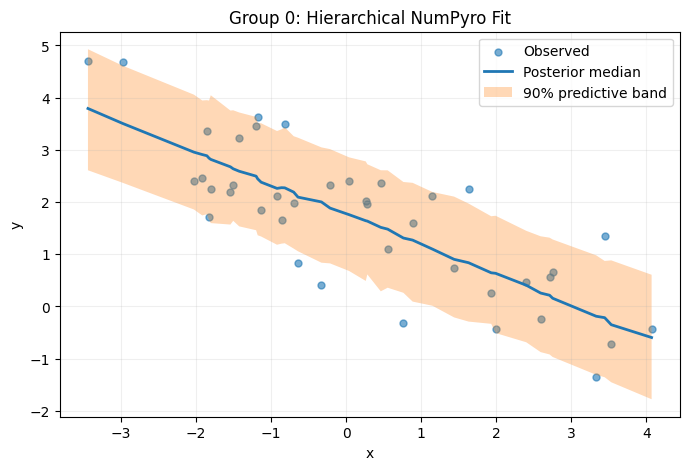

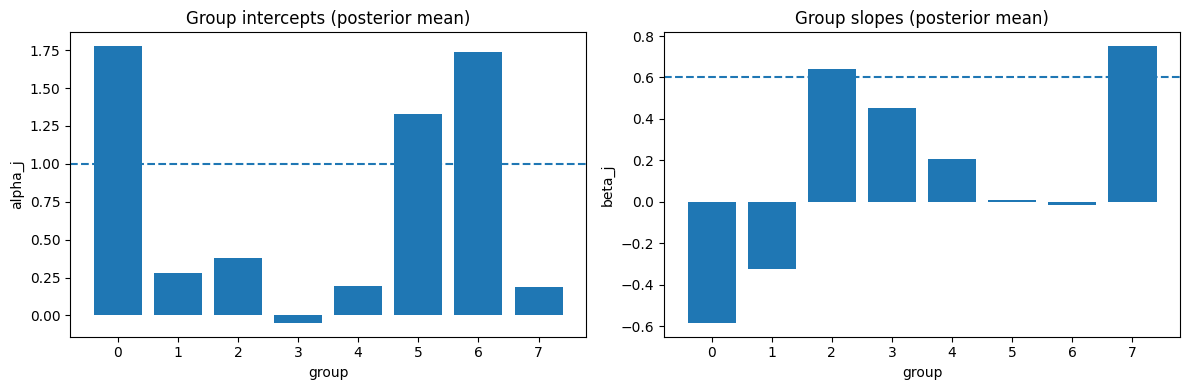


Done: hierarchical Bayesian regression in NumPyro with NUTS and PPC.


In [16]:
alpha_g = np.asarray(samples["alpha_g"]).mean(axis=0)
beta_g = np.asarray(samples["beta_g"]).mean(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(range(n_groups), alpha_g)
axes[0].axhline(truth["true_alpha"], linestyle="--")
axes[1].bar(range(n_groups), beta_g)
axes[1].axhline(truth["true_beta"], linestyle="--")
plt.tight_layout()
plt.show()